In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io.wavfile import write
from datetime import datetime
import subprocess
from scipy.interpolate import LinearNDInterpolator

In [3]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [4]:
def vectorized_interpolation(array, indices): # indices.shape (dim_array, desired number of interpolations)
    if len(array.shape) == 0: return array
    t = indices[0] % 1
    floor_indices = np.floor(indices[0]).astype(int)
    ceil_indices  = np.ceil (indices[0]).astype(int)
    return (1 - t) * vectorized_interpolation(array[floor_indices], indices[1:]) + t * vectorized_interpolation(array[ceil_indices], indices[1:])

In [5]:
vectorized_interpolation(np.array([[0, 1, 2], [10, 20, 30]]), np.array([0.5, 0.5]))

7.75

In [6]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)

    # potential-part
    next_psi = psi * np.exp(1j * dt * potential)

    next_psi = np.fft.fft2(next_psi)

    indices = 2 * np.pi * np.min([np.arange(n), n-np.arange(n)], axis=0)
    k = indices.reshape(-1, 1)
    l = indices.reshape(1, -1)
    theta = (k*k + l*l) * dt
    next_psi *= np.exp(1j * theta)

    next_psi = np.fft.ifft2(next_psi)
    return next_psi

In [7]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [8]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y)
    

In [9]:
parabolar(64, 0, 128, [0, 0], 1)

1.0

In [10]:
def circle(rad, radius, offset, n):
    return (radius * np.array([np.cos(rad), np.sin(rad)]) + offset) * n//2 + n//2

In [11]:
np.concatenate(([5], circle(0, 1, 0, 128)), axis=0)

array([  5., 128.,  64.])

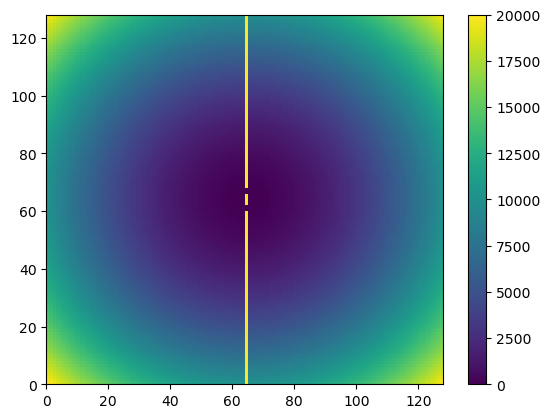

Finished simulation


In [12]:
n = 128
fps = 400
skip_frames = 20
duration = 5
simulation_speed = 0.005

slits_distance = 4
slits_width = 2
wall_height = 1e60

frames = np.empty((duration * fps, n, n), dtype=complex) # for storing the generated images

psi = np.array([[gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=10000) for x in range(n)] for y in range(n)])
potential[:64-slits_distance//2-slits_width, 64] = wall_height
potential[64+slits_distance//2+slits_width:, 64] = wall_height
potential[64-slits_distance//2:64+slits_distance//2, 64] = wall_height
frames[0] = psi

#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(potential, vmin=0, vmax=20000)
plt.colorbar()
plt.show()


for i in range(1, fps*duration):
    psi = calculate_next_psi(psi, simulation_speed / fps, potential)
    frames[i] = psi

print("Finished simulation")

# Video

In [13]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_filename = f'simulation_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'
video = cv2.VideoWriter(video_filename, fourcc, fps/skip_frames, (800, 600))
for i, frame in enumerate(frames[::skip_frames]):
    plt.figure(figsize=(8, 6))
    plot = plt.pcolormesh(pow(np.abs(frame), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
    plt.colorbar()
    plt.title('psi')

    # Save to temporary file
    plt.savefig('temp_frame.png')
    plt.close()

    # Read the image and add to the video
    img = cv2.imread('temp_frame.png')
    video.write(img)

print(f"Video saved as {video_filename}")
video.release()

Video saved as simulation_2024_04_12-11_03_22.mp4


# Sonification

In [14]:
sample_rate = 44100
frequency = 220
radius = 0.6

In [17]:
# Sonification
frames_indices = np.arange(duration * sample_rate) / sample_rate * fps
radians_per_sample = 2 * np.pi * frequency / sample_rate
radians = np.arange(duration * sample_rate) * radians_per_sample
x = np.cos(radians)
y = np.sin(radians)
interpolator = LinearNDInterpolator(np.array([frames_indices.ravel(), x.ravel(), y.ravel()]).T, frames.ravel())
audio = np.square(np.abs(interpolator((frames_indices, x, y), frames)))

print("Finished sonicifaction")

ValueError: different number of values and points

In [37]:
audio[:1000]  *= np.square(np.linspace(start=0, stop=1, num=1000, endpoint=False))
audio[-1000:] *= np.square(np.linspace(start=1, stop=0, num=1000, endpoint=False))
audio_filename = f'sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as sonification_2024_04_12-10_32_28.wav


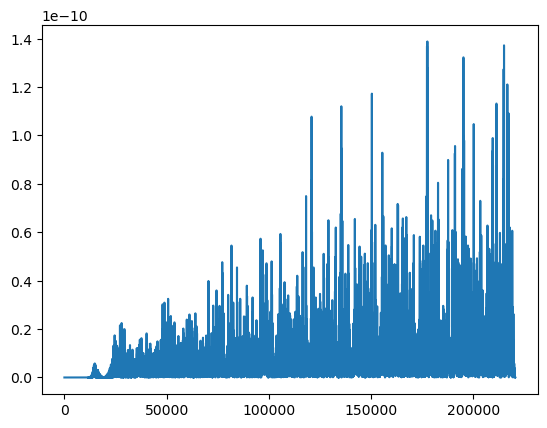

In [38]:
plt.plot(audio)

# Combine Video & Audio

In [39]:
combined_filename = f'combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    './ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 6.1.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--stat

CompletedProcess(args=['./ffmpeg', '-i', 'simulation_2024_04_12-10_30_15.mp4', '-i', 'sonification_2024_04_12-10_32_28.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'combination_2024_04_12-10_33_09.mp4'], returncode=0)